# 基于距离的平面点模式统计方法

## Introduction

点模式的基于距离的方法有三种类型：

* [Mean Nearest Neighbor Distance Statistics](#Mean-Nearest-Neighbor-Distance-Statistics)
* [Nearest Neighbor Distance Functions](#Nearest-Neighbor-Distance-Functions)
* [Interevent Distance Functions](#Interevent-Distance-Functions)

此外，我们将介绍一种计算技术[Simulation Envelopes](#Simulation-Envelopes)，以帮助对数据生成过程进行推断。 [示例](#CSR-Example) 用于演示如何使用和解释模拟包络。

In [1]:
from scipy import spatial
import libpysal as ps
import numpy as np
from pointpats import ripley
%matplotlib inline
import matplotlib.pyplot as plt

## 平均最近邻距离统计

点$u$的最近邻是满足条件的点$N(u)$
$$d_{u,N(u)} \leq d_{u,j} \forall j \in S - u$$

最近邻居 $N(u)$ 和点 $u$ 之间的距离是 $u$ 的最近邻居距离。 在为所有点搜索最近邻并计算相应距离后，我们可以通过对这些距离进行平均来计算平均最近邻距离。

Clark 和 Evans(1954) 证明，平均最近邻距离统计分布是零假设下的正态分布（底层空间过程是 CSR）。 我们可以利用测试统计来确定点模式是否是 CSR 的结果。 如果不是，是集群的结果还是常规的
空间过程？

In [2]:
points = np.array([[66.22, 32.54], [22.52, 22.39], [31.01, 81.21],
                   [9.47, 31.02],  [30.78, 60.10], [75.21, 58.93],
                   [79.26,  7.68], [8.23, 39.93],  [98.73, 77.17],
                   [89.78, 42.53], [65.19, 92.08], [54.46, 8.48]])

## 最近邻距离函数

点过程的最近邻距离分布函数（包括最近的“事件到事件”和“点到事件”距离分布函数）是几种累积分布函数——$G、F、J$。 通过将观察到的点模式的距离函数与来自 CSR 过程的点模式的距离函数进行比较，我们能够推断观察到的点模式的潜在空间过程是否为给定置信度的 CSR。

#### $G$ 函数 - 事件到事件

$G$ 函数是一种描述点模式内距离分布的“累积”密度。 对于给定的距离 $d$，$G(d)$ 是最近邻距离小于 $d$ 的比例。 为了表达这一点，我们首先需要定义最近邻距离，即每个观察值 $i$ 到其他观察值 $j$ 的最小距离，其中 $j \neq i$：
$$ min_{j\neq i}\{d_{ij}\} = d^*_i $$

有了这个，我们可以将 $G$ 函数定义为累积密度函数：
$$G(d) = \frac{1}{N}\sum_{i=1}^N \mathcal{I}(d^*_i < d)$$
其中 $\mathcal{I}(.)$ 是一个*指示函数*，当参数为真时为 $1$，否则为零。 简单来说，$G(d)$给出了小于$d$的最近邻距离（$d^*_i$）的百分比； 当 $d$ 非常小时，$G(d)$ 接近于零。 当 $d$ 很大时，$G(d)$ 接近 1。

假定研究区域中定位点的“空”过程在空间上是完全随机的，则可以获得有关 $G$ 的分析结果。 在一个完全空间随机的过程中，$G(d)$ 值应该是：
$$
G(d) = 1-e^{-\lambda \pi d^2}
$$
实际上，我们使用模拟评估 $G(d)$ 函数的统计显着性，其中生成已知的空间随机过程，然后进行分析。 这部分解释了形状不规则的研究区域的问题，其中点的位置受到限制。

在实践中，我们使用 `ripley.g_test` 函数对 $G(d)$ 进行测试。 它估计一组值的 $G(d)$ 值（称为“支持度”）。 为 $d$ 的十个值计算 $G$ 函数，范围从数据中的最小可能值到最大值：

In [3]:
g_test = ripley.g_test(points, support=10)

`pointpats.distance_statistics` 中的所有统计测试都返回一个具有以下属性的 `collections.namedtuple` 对象：
- `support`，其中包含用于计算距离统计的距离值（$d$）。
- `statistic`，它表示在 `support` 中每个 $d$ 值处所请求函数的值。
- `pvalue`，表示比观察到的统计数据更极端的观察到的模拟（在完全空间随机过程下）的分数。
- `simulations`，存储空间随机过程下统计的模拟值。 通常，这*不会*保存（出于效率原因），但可以使用“keep_simulations”请求。

In [4]:
g_test.support

array([ 0.        ,  3.84791574,  7.69583148, 11.54374723, 15.39166297,
       19.23957871, 23.08749445, 26.93541019, 30.78332593, 34.63124168])

In [5]:
g_test.statistic

array([0.        , 0.        , 0.        , 0.16666667, 0.16666667,
       0.25      , 0.58333333, 0.83333333, 0.91666667, 1.        ])

In [6]:
g_test.pvalue

array([0.    , 0.    , 0.    , 0.0281, 0.0008, 0.0003, 0.0051, 0.0652,
       0.076 , 0.    ])

In [7]:
g_test.simulations

为了绘制统计图，“统计”通常绘制在垂直轴上，“支持”绘制在水平轴上。 在这里，我们还将显示 $G(d)$ 的中值模拟值。

In [8]:
g_test = ripley.g_test(points, support=10, keep_simulations=True)

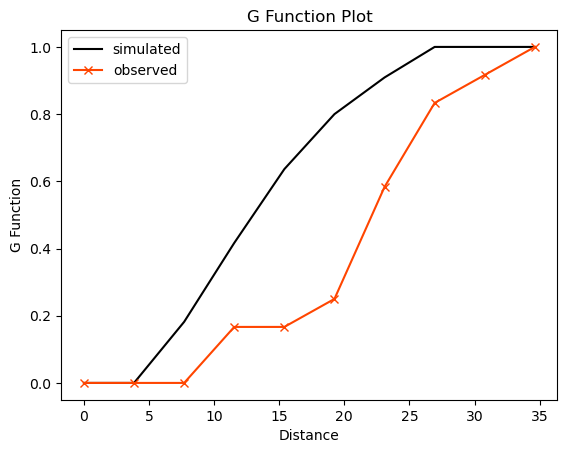

In [9]:
plt.plot(g_test.support, np.median(g_test.simulations, axis=0), 
         color='k', label='simulated')
plt.plot(g_test.support, g_test.statistic, 
         marker='x', color='orangered', label='observed')
plt.legend()
plt.xlabel('Distance')
plt.ylabel('G Function')
plt.title('G Function Plot')
plt.show()

如您所见，$G$ 函数在小距离处增加非常缓慢，并且该线低于典型的模拟值（以黑色显示）。 我们可以通过查看每个点的 p 值并绘制模拟的 $G(d)$ 曲线来验证此处的视觉直觉：

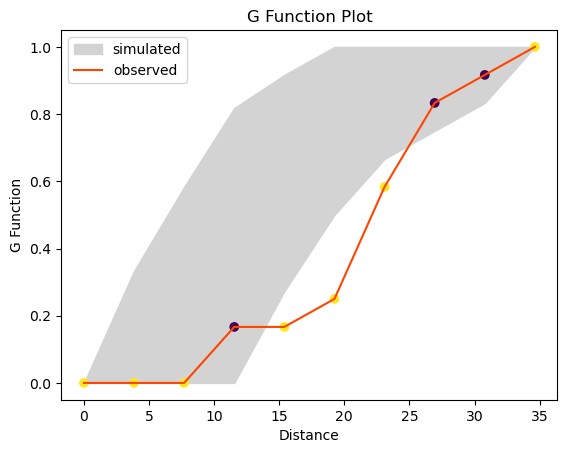

In [10]:
# grab the middle 95% of simulations using numpy:
middle_95pct = np.percentile(g_test.simulations, q=(2.5, 97.5), axis=0)
# use the fill_between function to color between the 2.5% and 97.5% envelope
plt.fill_between(g_test.support, *middle_95pct, 
                 color='lightgrey', label='simulated')

# plot the line for the observed value of G(d)
plt.plot(g_test.support, g_test.statistic, 
         color='orangered', label='observed')
# and plot the support points depending on whether their p-value is smaller than .05
plt.scatter(g_test.support, g_test.statistic, 
            cmap='viridis', c=g_test.pvalue < .01)
plt.legend()
plt.xlabel('Distance')
plt.ylabel('G Function')
plt.title('G Function Plot')
plt.show()

由此，我们可以看到在 $d$ 的小值处存在统计上显着的“离散”，因为在 $0 < d < 25$ 之间观察到的最近邻距离“太少”了。 一旦我们到达非常远的距离，模拟包络就会覆盖观察到的统计数据。 因此，我们可以说记录在“points”中的点模式异常分散。

要在不考虑任何统计显着性或模拟的情况下评估 $G(d)$ 函数，您可以使用 `ripley` 模块中的 `g_function`，它只返回 $G(d)$ 的距离和值。

In [11]:
ripley.g_function(points)

(array([ 0.        ,  1.82269693,  3.64539386,  5.46809079,  7.29078772,
         9.11348465, 10.93618158, 12.75887851, 14.58157544, 16.40427237,
        18.2269693 , 20.04966623, 21.87236316, 23.69506009, 25.51775702,
        27.34045395, 29.16315088, 30.98584782, 32.80854475, 34.63124168]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.25      ,
        0.25      , 0.25      , 0.41666667, 0.58333333, 0.75      ,
        0.83333333, 0.83333333, 0.91666667, 0.91666667, 1.        ]))

#### $F$ 函数 - “点事件”

当一个点模式中的事件数较少时，$G$函数就很粗糙。 对于 points 中包含的模式，只有 12 个观察值！ 这意味着只有 12 个最近邻距离，因此 $G(d)$ 统计量在任何 $d$ 处只有 12 个可能的值。

解决这个问题的一种方法是转向另一种方法，即 $F(d)$ 函数。 这类似于 $G(d)$ 函数，但测量最近邻距离*从*一组已知随机分布的点*到*观察到的模式中的一个点。 另一种思考 $F(d)$ 的方式是，它反映了一种*模式间*离散度量，其中一种模式在空间上完全随机，另一种模式是我们观察到的模式。 相比之下，$G(d)$ 是一种*模式内*分散度量。

对于大小为 $N_s$ 的随机模拟点模式，这使得 $F(d)$ 函数：

$$F(d) = \frac{1}{N_s} \sum_k^{N_s} \mathcal{I}(d^*_k < d)$$

对于任何 $d$，这可以有 $N_s$ 个可能的值，因此可以提供更细粒度的点模式视图。 从这个意义上讲，$F(d)$ 函数通常称为*空白空间函数*，因为它测量从“空白空间”中的随机点到点模式中“填充”点的距离。 这些随机点的数量决定了我们对观察到的点模式的测量的“细粒度”程度。

就像 `ripley.g_test` 一样，此函数针对支持中的每个 $d$ 进行评估。 此外，我们可以为“支持”提供*自定义*值，以防我们知道感兴趣的距离值。

下面，我们将使用 $G(d)$ 函数中相同的十个“支持”值。 并且，让我们将“模拟”点模式限制在我们原始点模式的凸包内：

In [12]:
f_test = ripley.f_test(points, support = g_test.support, keep_simulations=True, hull='convex')

由于 $F(d)$ 函数非常平滑，我们可以通过直接将其值绘制为线来清楚地看到 $F(d)$ 统计量及其模拟。 对于模拟值，我们将使它们非常透明。 和以前一样，我们将使用“pvalue”属性可视化统计显着性：

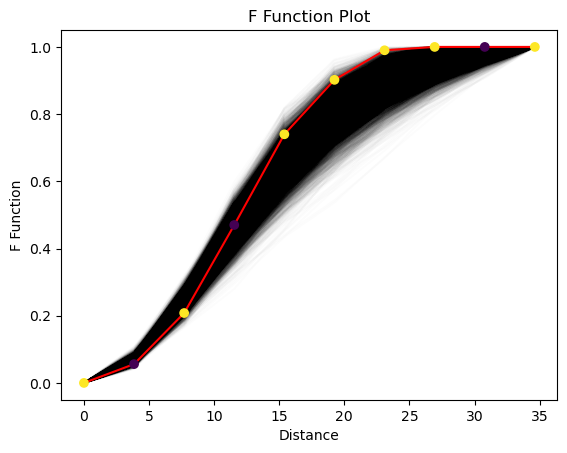

In [13]:
plt.plot(f_test.support, f_test.simulations.T, alpha=.01, color='k')
plt.plot(f_test.support, f_test.statistic, color='red')

plt.scatter(f_test.support, f_test.statistic, 
            cmap='viridis', c=f_test.pvalue < .05,
            zorder=4 # make sure they plot on top
           )

plt.xlabel('Distance')
plt.ylabel('F Function')
plt.title('F Function Plot')
plt.show()

plt.show()

从这里我们看到 $F$ 函数的值对于从大约 15 到 25 的距离“太高”，并且（相反）对于 $5 < d < 10$ 之间的值，$F(d)$ 函数具有 短距离太少。 当观察到的 $F(d)$ 值太大时，则模式太分散或太规则。 如果经验 $F(d)$ 倾向于低于模拟值，则它反映了聚类。 这与上面$G(d)$ 函数的解释*相反*，所以要小心！

#### $J$ 函数 - “事件-事件”和“点-事件”的组合

$J$ 函数结合了 $G$ 和 $F$ 函数，试图提供内部聚类和相对于空白空间分布的即时图形指示。 实际上，$J(d)$ 函数被计算为一种“相对聚类率”：

$$J(d) = \frac{1-G(d)}{1-F(d)}$$

其中分子捕获由于模式内距离引起的聚类，分母捕获模式到空距离的聚类。 这意味着当$J(d)<1$时，底层点过程为簇点过程，当$J(d)=1$时，底层点过程为随机点过程； 否则，它是一个散点过程。

此功能可能会遇到数值稳定性问题； 由于 $G(d)$ 和 $F(d)$ 都接近 $1$，$J$ 比率可能会变得混乱。 此外，当 $G$ 或 $F$ 达到 1 时，$J$ 函数会突然改变。 因此，$J$ 函数通常*截断*为第一个 $1$（在 $F(d)$ 或 $G(d)$ 中），以及 $F$ 和 $G$ 中的任何 $d$ $1$ 被赋予 $J$ 值 $1$。

In [28]:
jp1 = ripley.j_test(points, support=20)

d:\work\miniconda3\lib\site-packages\pointpats\ripley.py:893: UserWarning: requested 20 bins to evaluate the J function, but it reaches infinity at d=25.5178, meaning only 14 bins will be used to characterize the J function.
  observed_support, observed_statistic = stat_function(


从上面的警告中可以看出，$J$ 函数在大约 $d=25$ 时确实遇到了数值稳定性问题。 为了解决这个问题，`pointpats` 将 $J$ 函数截断为仅支持 14 个值，而不是请求的 $20$。

Text(0, 0.5, 'J Function')

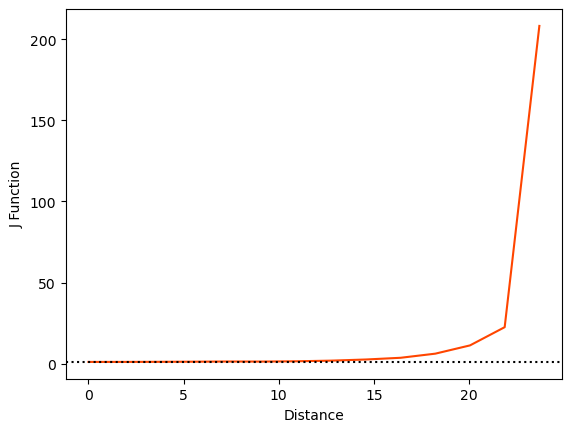

In [29]:
plt.plot(jp1.support, jp1.statistic, color='orangered')
plt.axhline(1, linestyle=':', color='k')
plt.xlabel('Distance')
plt.ylabel('J Function')

从上图中，我们看到 $J$ 函数位于 $J(d)=1$ 水平线上方，尤其是当 $d$ 变大时。 这表明该过程过度分散。 

## 干预距离函数

虽然 $F(d)$ 和 $G(d)$ 函数都很有用，但它们只考虑每个点 $i$ 与其最近点之间的距离。 前面我们把这个距离拼写为$d_i^*$，$i$和$j$之间的距离就是$d_{ij}$。 因此，请注意 $d_{i}^*$ 是*唯一*对 $F$ 和 $G$ 重要的术语，如果 $d_{ij}$ 发生变化（但 $j$ 并不最接近 $i$ )，则 $F$ 和 $G$ 函数通常保持不变。

因此，已经开发了进一步的统计汇总函数来考虑*整个*距离分布，而不仅仅是最近邻距离。 这些函数（仍然被认为是“Ripley”字母表的一部分，是 $K$ 和 $L$ 函数。

#### $K$ 函数

$K(d)$ 函数是点模式内*所有*距离的累积密度函数的缩放版本。 因此，它是考虑所有距离的 $G$ 函数的“相对”，而不仅仅是最近邻距离。 实际上，$K(d)$ 函数可以被认为是小于 $d$ 的所有距离的百分比。 因此，对于阈值距离 $d$，$K$ 函数定义为：

$$K(d) = \frac{1}{N\hat\lambda} \underset{i=1}{\overset{N}{\sum}}\underset{j=1}{\overset{N} {\sum}} \mathcal{I}\left(d_ij < d\right)$$

在这个等式中，$\hat\lambda$ 是点过程的*强度*。 这表示您在一个单位区域中期望的点数（平均）。 您可以将其视为模式中点的*密度*的类比：较大的 $\hat\lambda$ 值表示每个区域有很多点，较小的 $\hat\lambda$ 值表示较少的点 每个区域。 通常，此参数是未知的，并使用研究区域中的平均点数建模。 这假设点模式的强度在研究区域是*恒定*或*均匀*。

以与之前相同的方式，我们可以为随机点模式构造一组 $K(d)$ 函数评估，并将它们与我们在原始数据中看到的观察到的 $K(d)$ 函数进行比较。

In [16]:
k_test = ripley.k_test(points, keep_simulations=True)

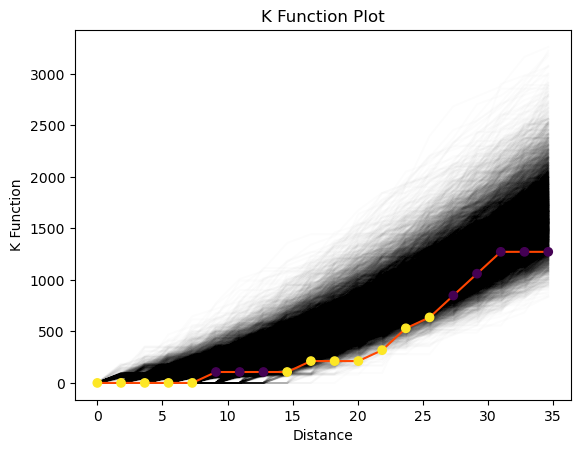

In [17]:
plt.plot(k_test.support, k_test.simulations.T, color='k', alpha=.01)
plt.plot(k_test.support, k_test.statistic, color='orangered')

plt.scatter(k_test.support, k_test.statistic, 
            cmap='viridis', c=k_test.pvalue < .05,
            zorder=4 # make sure they plot on top
           )

plt.xlabel('Distance')
plt.ylabel('K Function')
plt.title('K Function Plot')
plt.show()

同样，我们可以看到包络通常高于观察到的函数，这意味着我们的点模式是分散的。 我们可以得出这个结论，因为距离*太小*，表明该模式的聚集程度低于预期。 当点太规则时，它们的距离往往比随机分布时更小。

#### $L$ 函数 - “interevent”

$L$ 函数是 $K$ 函数的缩放版本，定义它是为了帮助解释。 $K(d)$ 函数的期望值随着 $d$ *增加*； 这是有道理的，因为接近 $d$ 的点对的数量将随着 $d$ 的增加而增加。 因此，我们可以定义 $K$ 的规范化，当 $d$ 增加时*消除*这种增加。

$$L(d) = \sqrt{\frac{K(d)}{\pi}}-d$$

对于空间随机的模式，$L(d)$ 在所有 $d$ 值处都是 $0$。 因此，我们可以使用此标准化来更轻松地可视化 $K$ 函数的结果：

In [18]:
l_test = ripley.l_test(points, keep_simulations=True)

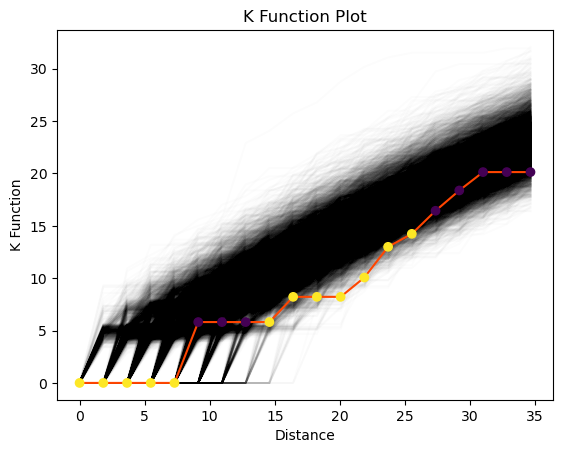

In [19]:
plt.plot(l_test.support, l_test.simulations.T, color='k', alpha=.01)
plt.plot(l_test.support, l_test.statistic, color='orangered')

plt.scatter(l_test.support, l_test.statistic, 
            cmap='viridis', c=l_test.pvalue < .05,
            zorder=4 # make sure they plot on top
           )

plt.xlabel('Distance')
plt.ylabel('K Function')
plt.title('K Function Plot')
plt.show()

## CSR 示例

在这个例子中，我们将生成一个点模式作为“观察到的”点模式。 这确保了数据生成过程在空间上是完全随机的。 然后，我们将在同一域中模拟 CSR 100 次，并为这些模拟构造评估 ripley 函数。

In [20]:
import geopandas
df = geopandas.read_file(ps.examples.get_path("vautm17n.shp"))
state = df.geometry.cascaded_union

C:\Users\24365\AppData\Local\Temp\ipykernel_1064\4092422693.py:3: FutureWarning: The 'cascaded_union' attribute is deprecated, use 'unary_union' instead
  state = df.geometry.cascaded_union


从 CSR 生成点模式 **pp**（大小 100）作为“观察到的”点模式。

In [21]:
pattern = ripley.simulate(state, size=100)

在我们继续之前，让我们想象一下这些模拟值：

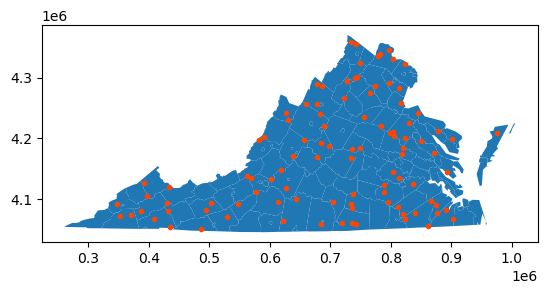

In [22]:
df.plot()
plt.scatter(*pattern.T, color='orangered', marker='.')
plt.show()

并且，让我们检查是否有 100 个点：

In [23]:
pattern.shape

(100, 2)

是的！ 因此，接下来要以相同的方式模拟一组实现，我们可以再次使用 size 参数，就像 numpy.random 模拟器一样。 这意味着，要模拟大小为 $N$ 的模式的 $K$ 实现，然后我们使用 `simulate(hull, size=(N,K)`。对于一个实现，我们可以使用 `size=N`。

In [24]:
random_realizations = ripley.simulate(state, size=(100,100))

为了显示随机模式是真正随机的，我们可以可视化所有的点：

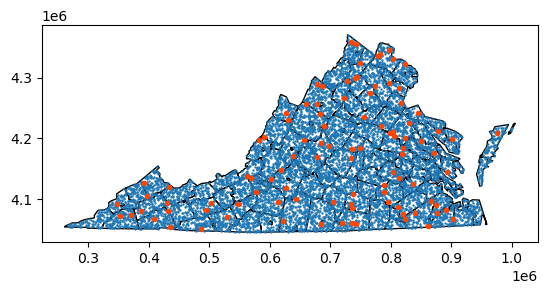

In [25]:
df.plot(facecolor='none', edgecolor='k')
plt.scatter(*random_realizations.T, marker='.', s=2)
plt.scatter(*pattern.T, color='orangered', marker='.')
plt.show()

现在让我们为观察到的模式以及我们刚刚实现的所有实现计算“G”函数。

In [26]:
observed_g = ripley.g_function(pattern)
comparison_g = [ripley.g_function(realization, support=observed_g[0]) 
                for realization in random_realizations]

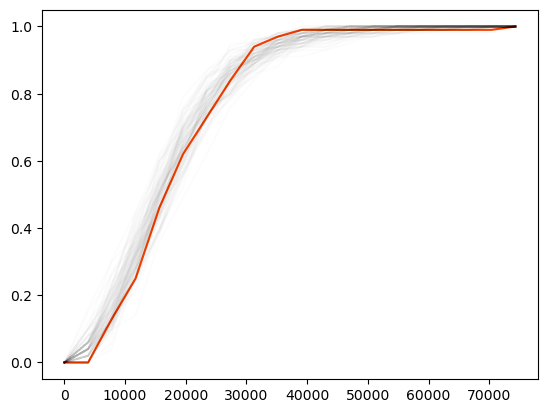

In [27]:
plt.plot(*observed_g, color='orangered')
[plt.plot(*comparison, color='k', alpha=.01) 
 for comparison in comparison_g]
plt.show()